In [1]:
!pip install d2l==1.0.3
!pip install numpy scikit-learn

# Gaussian Process Priors

A _Gaussian Process_ is a powerful tool in machine learning used to model functions. Unlike traditional models that assume a specific form for the function (like a linear equation), GPs treat the function as a distribution over possible functions. This means instead of having a single function, we have a whole family of functions that could explain the data.

Key Points:
- Collection of Random Variables: A GP is a collection of random variables, any finite number of which have a joint _Gaussian (normal) distribution.

- Function Representation: It provides a distribution over functions, allowing us to model uncertainty in our predictions.

Example:
Imagine you're trying to predict the temperature at different times of the day. Instead of assuming a fixed temperature curve, a GP allows you to consider a range of possible temperature curves, each with its own likelihood.

## 1. Definition

A **Gaussian Process (GP)** is a way to put a probability distribution over functions. Instead of choosing one exact function, we consider a whole family of plausible functions consistent with our prior beliefs and the observed data.

Formally:

$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$

where:
- $f(x)$ is the function we're modeling.
- **Mean Function** $m(x)$: expected value of $f(x)$ at $x$ (often $0$ for simplicity).
- **Covariance Function** $k(x, x')$: how related (similar) $f(x)$ and $f(x')$ are. A large $k(x,x')$ means the two values tend to move together.

This means that for any set of input points $x_1,x_2,...,x_n$, the corresponding function values $f(x_1),f(x_2),...,f(x_n)$ follow a joint Gaussian (normal) distribution. Then any collection of function values queried at any collection of input points $x$ (times, spatial locations, image pixels, etc.), has a joint multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $K$: $f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)$, where $\mu_i = E[f(x_i)] = m(x_i)$ and $K_{ij} = \textrm{Cov}(f(x_i),f(x_j)) = k(x_i,x_j)$.

This definition may seem abstract and inaccessible, but Gaussian processes are in fact very simple objects. Any function

<a id="eq-gp-function"></a>
$$
f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle \tag{18.2.1}
$$

with $w$ is a vector of weights drawn from a Gaussian (normal) distribution, and $\phi$ being any vector of basis functions, for example $\phi(x) = (1, x, x^2, ..., x^d)^{\top}$,
is a Gaussian process. Moreover, any Gaussian process f(x) can be expressed in the form of equation [(18.2.1)](#eq-gp-function). Let's consider a few concrete examples, to begin getting acquainted with Gaussian processes, after which we can appreciate how simple and useful they really are.

An example code demonstrate GP prior (RBF kernel):

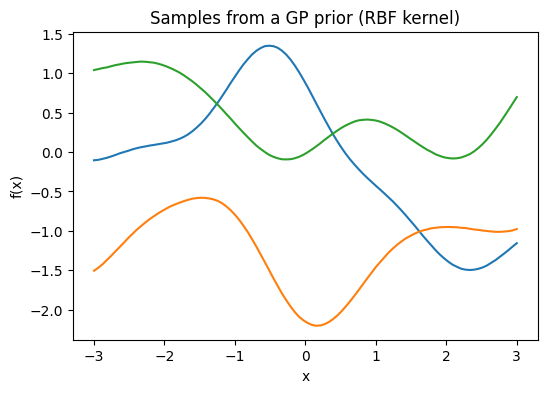

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define mean and RBF kernel
def m(x):
    return np.zeros_like(x)  # zero mean

def rbf_kernel(X1, X2, sigma2=1.0, ell=1.0):
    # |X1|x|X2| -> Gram matrix
    X1 = X1[:, None]
    X2 = X2[None, :]
    sqdist = (X1 - X2)**2
    return sigma2 * np.exp(-0.5 * sqdist / ell**2)

# 2. Choose input points
X = np.linspace(-3, 3, 100)
K = rbf_kernel(X, X, sigma2=1.0, ell=1.0)

# 3. Sample from the multivariate normal (GP prior)
num_samples = 3
y_samples = np.random.multivariate_normal(mean=m(X), cov=K + 1e-6*np.eye(len(X)), size=num_samples)

# 4. Plot
plt.figure(figsize=(6,4))
plt.plot(X, y_samples.T)
plt.title("Samples from a GP prior (RBF kernel)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


## 2. A Simple Gaussian Process

Suppose $f(x) = w_0 + w_1 x$, and $w_0, w_1 \sim \mathcal{N}(0,1)$, with $w_0, w_1, x$ all in one dimension. We can equivalently write this function as the inner product $f(x) = (w_0, w_1)(1, x)^{\top}$. In [(18.2.1)](#eq-gp-function) above, $w = (w_0, w_1)^{\top}$ and $\phi(x) = (1,x)^{\top}$.

For any $x$, $f(x)$ is a sum of two Gaussian random variables. Since Gaussians are closed under addition, $f(x)$ is also a Gaussian random variable for any $x$. In fact, we can compute for any particular $x$ that $f(x)$ is $\mathcal{N}(0,1+x^2)$. Similarly, the joint distribution for any collection of function values, $(f(x_1),\dots,f(x_n))$, for any collection of inputs $x_1,\dots,x_n$, is a multivariate Gaussian distribution. Therefore $f(x)$ is a Gaussian process.

In short, $f(x)$ is a _random function_, or a _distribution over functions_. We can gain some insights into this distribution by repeatedly sampling values for $w_0, w_1$, and visualizing the corresponding functions $f(x)$, which are straight lines with slopes and different intercepts, as follows with $\alpha^2 = 1.0$:

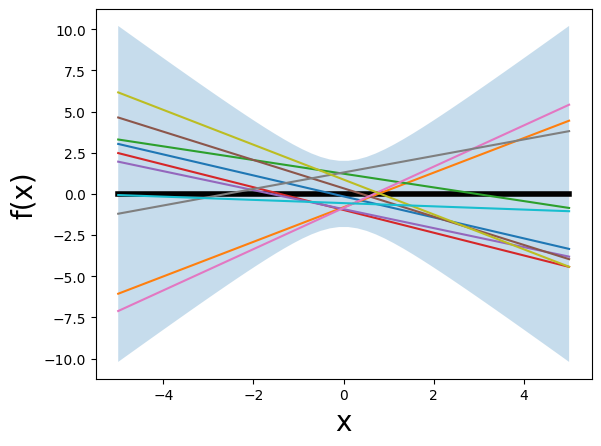

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the linear function with PyTorch
def lin_func(x, n_sample):
    preds = torch.zeros((n_sample, x.shape[0]))  # Initialize the prediction tensor
    for ii in range(n_sample):
        w = torch.normal(0, 1, (2,))  # Sample weights from a normal distribution
        y = w[0] + w[1] * x  # Linear equation
        preds[ii, :] = y  # Store the prediction
    return preds

# Generate x_points as a PyTorch tensor
x_points = torch.linspace(-5, 5, 50)

# Generate outputs with 10 samples
outs = lin_func(x_points, 10)

# Compute the lower and upper bounds
lw_bd = -2 * torch.sqrt(1 + x_points ** 2)
up_bd = 2 * torch.sqrt(1 + x_points ** 2)

# Plotting with Matplotlib
plt.fill_between(x_points.numpy(), lw_bd.numpy(), up_bd.numpy(), alpha=0.25)
plt.plot(x_points.numpy(), torch.zeros(len(x_points)).numpy(), linewidth=4, color='black')

# Plot each of the 10 samples (outputs)
for i in range(outs.shape[0]):
    plt.plot(x_points.numpy(), outs[i, :].numpy())

plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.show()


If $w_0$ and $w_1$ are instead drawn from $\mathcal{N}(0,\alpha^2)$, how do you imagine varying $\alpha$ affects the distribution over functions?
So with this we will show different $\alpha^2 = 0.1, 1.0, 4.0$

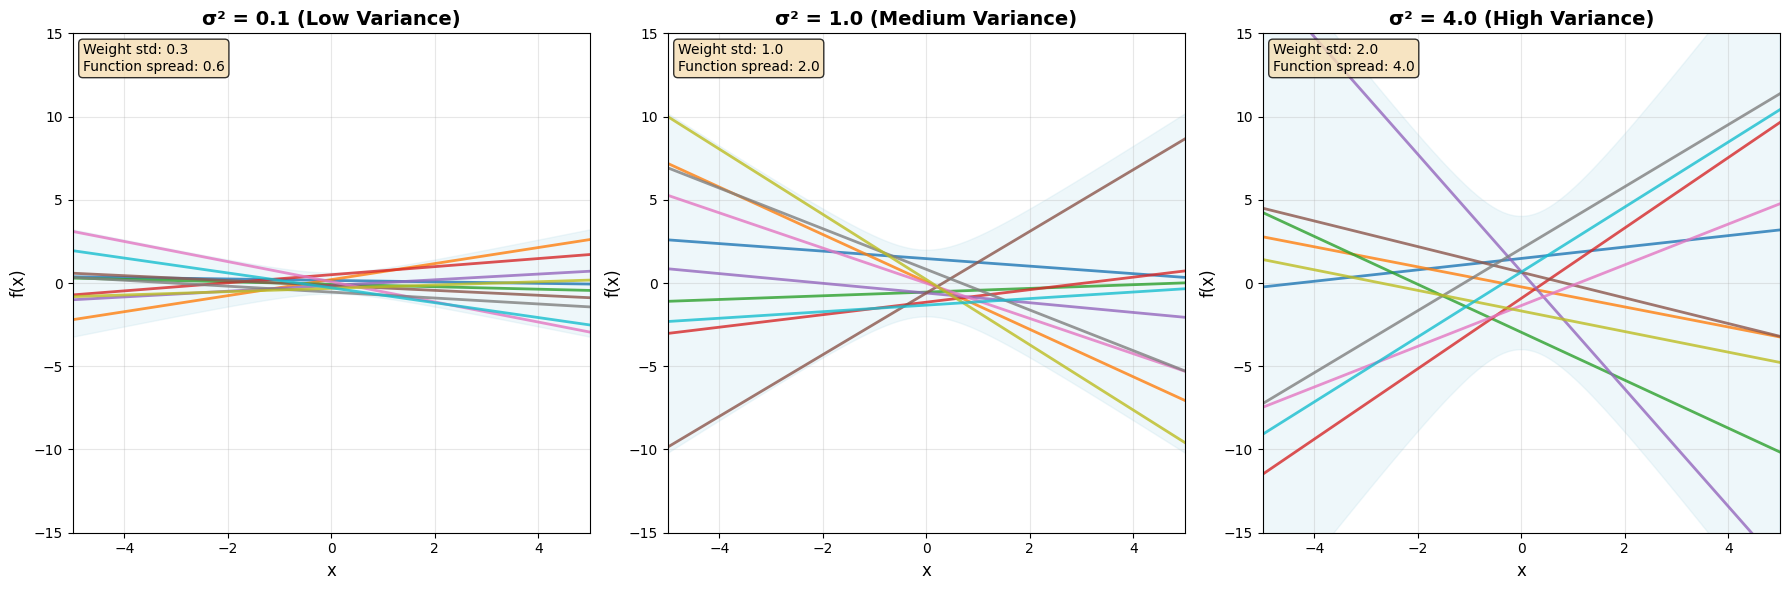

=== Hyperparameter Effects: Variance σ² ===
Linear GP: f(x) = w₀ + w₁x where w₀, w₁ ~ N(0, σ²)

Key Observations:
1. LOW VARIANCE (σ² = 0.1):
   - Functions stay close to zero
   - Small slopes and intercepts
   - Tight confidence bounds
   - Low variability in function shapes

2. MEDIUM VARIANCE (σ² = 1.0):
   - Moderate function variability
   - Balanced spread of slopes and intercepts
   - Medium confidence bounds

3. HIGH VARIANCE (σ² = 4.0):
   - Functions spread widely
   - Large slopes and intercepts possible
   - Wide confidence bounds
   - High variability in function shapes

=== Mathematical Relationship ===
• Weight distribution: w ~ N(0, σ²I)
• Function values: f(x) = w₀ + w₁x
• Variance at point x: Var[f(x)] = σ²(1 + x²)
• Standard deviation grows with |x| and σ
• Larger σ² → more diverse function samples


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Linear GP with different variance hyperparameters
def linear_gp_variance_comparison():
    # Define x range
    x = np.linspace(-5, 5, 100)
    
    # Different variance values to compare
    variances = [0.1, 1.0, 4.0]
    variance_labels = ['σ² = 0.1 (Low Variance)', 'σ² = 1.0 (Medium Variance)', 'σ² = 4.0 (High Variance)']
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Number of function samples to draw
    n_samples = 10
    
    for idx, (var, label) in enumerate(zip(variances, variance_labels)):
        ax = axes[idx]
        
        # Sample weights from N(0, σ²I) instead of N(0, I)
        w_samples = np.random.normal(0, np.sqrt(var), (n_samples, 2))  # [w0, w1] pairs
        
        # Plot each linear function
        for i in range(n_samples):
            w0, w1 = w_samples[i]
            y = w0 + w1 * x
            ax.plot(x, y, linewidth=2, alpha=0.8)
        
        # Add confidence region
        # For linear GP with variance σ², bounds scale with σ
        sigma = np.sqrt(var)
        upper_bound = 2 * sigma * np.sqrt(1 + x**2)
        lower_bound = -2 * sigma * np.sqrt(1 + x**2)
        ax.fill_between(x, lower_bound, upper_bound, alpha=0.2, color='lightblue')
        
        # Set common y-limits for comparison
        ax.set_xlim(-5, 5)
        ax.set_ylim(-15, 15)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('f(x)', fontsize=12)
        ax.set_title(label, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add text box with statistics
        textstr = f'Weight std: {np.sqrt(var):.1f}\nFunction spread: {2*np.sqrt(var):.1f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return variances

# Run the variance comparison
variances_used = linear_gp_variance_comparison()

print("=== Hyperparameter Effects: Variance σ² ===")
print("Linear GP: f(x) = w₀ + w₁x where w₀, w₁ ~ N(0, σ²)")
print("\nKey Observations:")
print("1. LOW VARIANCE (σ² = 0.1):")
print("   - Functions stay close to zero")
print("   - Small slopes and intercepts")
print("   - Tight confidence bounds")
print("   - Low variability in function shapes")

print("\n2. MEDIUM VARIANCE (σ² = 1.0):")
print("   - Moderate function variability")
print("   - Balanced spread of slopes and intercepts")
print("   - Medium confidence bounds")

print("\n3. HIGH VARIANCE (σ² = 4.0):")
print("   - Functions spread widely")
print("   - Large slopes and intercepts possible")
print("   - Wide confidence bounds")
print("   - High variability in function shapes")

print("\n=== Mathematical Relationship ===")
print("• Weight distribution: w ~ N(0, σ²I)")
print("• Function values: f(x) = w₀ + w₁x")
print("• Variance at point x: Var[f(x)] = σ²(1 + x²)")
print("• Standard deviation grows with |x| and σ")
print("• Larger σ² → more diverse function samples")


## 3. From Weight Space to Function Space

In the previous section, we saw how a distribution over parameters in a model leads to a distribution over functions. Although we usually have an idea of what kind of functions we want to model (e.g., smooth, periodic, or rapidly changing), it can be difficult to directly work with the parameters since they are often not very interpretable.

Fortunately, **Gaussian processes** provide an easier way to reason **directly** about the functions themselves. A **Gaussian distribution** is fully defined by its **mean** and **covariance matrix**. Similarly, a **Gaussian process** is characterized by its **mean function** and **covariance function**.

### **Mean Function**

Let's start by considering the **mean function**. The mean function gives us the expected value of the function $ f(x) $ at any point $ x $.

For example, let’s consider a simple linear function of the form:

$$
f(x) = w_0 + w_1 x
$$

where $ w_0 $ and $ w_1 $ are drawn from a Gaussian distribution. The **mean function** is simply the expected value of $ f(x) $:

$$
m(x) = E[f(x)] = E[w_0 + w_1 x] = E[w_0] + E[w_1]x = 0 + 0
$$

Since $ w_0 $ and $ w_1 $ have zero mean (as they are drawn from a normal distribution with mean 0). Thus, for this example, the mean function $ m(x) $ is 0 for all values of $ x $.

### **Covariance Function**

Next, let’s consider the **covariance function**. The covariance function describes how related the function values are at two different points, $ x $ and $ x' $.

The covariance function is defined as:

$$
k(x, x') = \textrm{Cov}(f(x), f(x')) = E[f(x)f(x')] - E[f(x)]E[f(x')].
$$

Since $ E[f(x)] = 0 $ and $ E[f(x')] = 0 $ (as shown above), this simplifies to:

$$
k(x, x') = E[f(x)f(x')].
$$

Now, let’s expand $ f(x) = w_0 + w_1 x $ and $ f(x') = w_0 + w_1 x' $:

$$
k(x, x') = E[(w_0 + w_1 x)(w_0 + w_1 x')] = E[w_0^2] + E[w_0 w_1 x'] + E[w_1 w_0 x] + E[w_1^2 x x'].
$$

Since $ w_0 $ and $ w_1 $ are independent, and both have 0 mean, the cross terms $ E[w_0 w_1] $ and $ E[w_1 w_0] $ = 0. We are left with:

$$
k(x, x') = E[w_0^2] + E[w_1^2] x x' = 1 + x x'.
$$

Since $ w_0 $ and $ w_1 $ are drawn from a normal distribution with variance 1.

### **General Case**

Now, let’s generalize this to any model of the form:

$$
f(x) = w^{\top} \phi(x)
$$

where $ \phi(x) $ is a vector of basis functions. These functions could be linear, polynomial, or even non-linear. If the weights $ w $ are drawn from a Gaussian distribution $ w \sim \mathcal{N}(u, S) $, we can calculate the **mean function** and **covariance function** for this more general model.

- The **mean function** is:

$$
m(x) = E[f(x)] = E[w^{\top} \phi(x)] = u^{\top} \phi(x).
$$

- The **covariance function** is:

$$
k(x, x') = \textrm{Cov}(f(x), f(x')) = E[f(x) f(x')] - E[f(x)] E[f(x')] = \phi(x)^{\top} S \phi(x').
$$

Here:
- $ u $ is the mean of the weight distribution.
- $ S $ is the covariance matrix of the weights.
- $ \phi(x) $ is a vector of basis functions, allowing for very flexible modeling.

This formulation is quite general and includes models with a potentially infinite number of parameters (for example, when using kernel methods in machine learning).

## 4. The Radial Basis Function (RBF) Kernel

The _radial basis function_ (RBF) kernel is the most popular covariance function for Gaussian processes, and kernel machines in general.
This kernel has the form $k_{\textrm{RBF}}(x,x') = a^2\exp\left(-\frac{1}{2\ell^2}||x-x'||^2\right)$, where $a$ is an amplitude parameter, and $\ell$ is a _lengthscale_ hyperparameter.

Let's derive this kernel starting from weight space. Consider the function

$$f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i  \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right), \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right). \tag{18.2.4}$$

$f(x)$ is a sum of radial basis functions, with width $\ell$, centred at the points $c_i$, as shown in the following figure.


We can recognize $f(x)$ as having the form $w^{\top} \phi(x)$, where $w = (w_1,\dots,w_J)^{\top}$ and $\phi(x)$ is a vector containing each of the radial basis functions. The covariance function of this Gaussian process is then

$$k(x,x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x'). \tag{18.2.5}$$

Now let's consider what happens as we take the number of parameters (and basis functions) to infinity. Let $c_J = \log J$, $c_1 = -\log J$, and $c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$, and $J \to \infty$. The covariance function becomes the Riemann sum:

$$k(x,x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x') = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x') dc. \tag{18.2.6}$$

By setting $c_0 = -\infty$ and $c_\infty = \infty$, we spread the infinitely many basis functions across the whole real line, each
a distance $\Delta c \to 0$ apart:

$$k(x,x') = \int_{-\infty}^{\infty} \exp(-\frac{(x-c)^2}{2\ell^2}) \exp(-\frac{(x'-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x')^2}{2(\sqrt{2} \ell)^2}) \propto k_{\textrm{RBF}}(x,x'). \tag{18.2.7}$$

For more details solving equation 18.2.4 to 18.2.7 you can go to [Go to Solving from equation [18.2.4] to [18.2.6]](#solving-from-equation-1824-to-1826)

It is worth taking a moment to absorb what we have done here. By moving into the function space representation, we have derived how to represent a model with an _infinite_ number of parameters, using a finite amount of computation. A Gaussian process with an RBF kernel is a _universal approximator_, capable of representing any continuous function to arbitrary precision. We can intuitively see why from the above derivation. We can collapse each radial basis function to a point mass taking $\ell \to 0$, and give each point mass any height we wish.

So a Gaussian process with an RBF kernel is a model with an infinite number of parameters and much more flexibility than any finite neural network. Perhaps all the fuss about _overparametrized_ neural networks is misplaced. As we will see, GPs with RBF kernels do not overfit, and in fact provide especially compelling generalization performance on small datasets. Moreover, the examples in [(Zhang et al., 2021)](#zhang2021understanding), such as the ability to fit images with random labels perfectly, but still generalize well on structured problems, (can be perfectly reproduced using Gaussian processes) [(Wilson and Izmailov, 2020)](#wilson2020bayesian). Neural networks are not as distinct as we make them out to be.

We can build further intuition about Gaussian processes with RBF kernels, and hyperparameters such as _length-scale_, by sampling directly from the distribution over functions. As before, this involves a simple procedure:

1. Choose the input $x$ points we want to query the GP: $x_1,\dots,x_n$.
2. Evaluate $m(x_i)$, $i = 1,\dots,n$, and $k(x_i,x_j)$ for $i,j = 1,\dots,n$ to respectively form the mean vector and covariance matrix $\mu$ and $K$, where $(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$.
3. Sample from this multivariate Gaussian distribution to obtain the sample function values.
4. Sample more times to visualize more sample functions queried at those points.

We illustrate this process in the figure below.

EXAMPLE 1: Basic GP Sampling Procedure
=== Gaussian Process Sampling Procedure ===

Step 1: Choose input points x₁, ..., xₙ
   → Chose 50 points from -3.0 to 3.0

Step 2: Evaluate m(xᵢ) and k(xᵢ, xⱼ) to form μ and K
   → Mean vector μ: shape (50,) (zero mean function)
   → Covariance matrix K: shape (50, 50)
   → K[0,0] = 1.000, K[0,1] = 0.993, K[0,-1] = 0.000000

Step 3: Sample from multivariate Gaussian N(μ, K)
   → First sample: f(x₁)=-0.302, f(x₂)=-0.314, ...

Step 4: Sample more times for visualization
   → Generated 5 function samples
   → Each sample represents function values [f(x₁), f(x₂), ..., f(xₙ)]


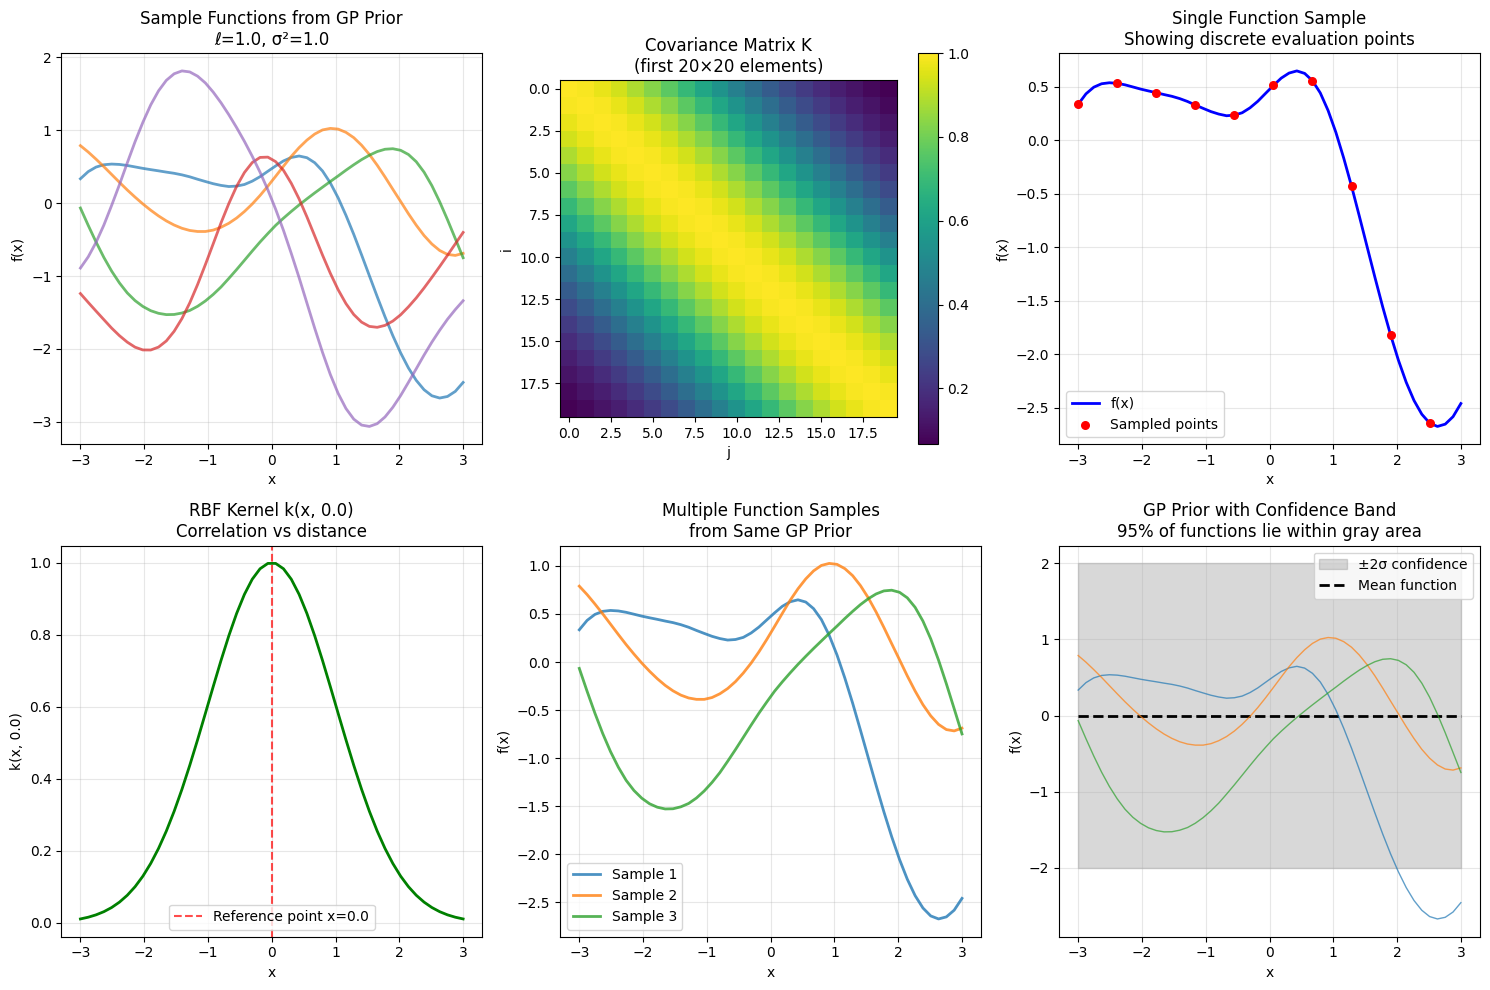


EXAMPLE 2: Hyperparameter Comparison
🔥 Comparing different hyperparameters:

Running procedure with Short length-scale (ℓ=0.5)...
=== Gaussian Process Sampling Procedure ===

Step 1: Choose input points x₁, ..., xₙ
   → Chose 60 points from -3.0 to 3.0

Step 2: Evaluate m(xᵢ) and k(xᵢ, xⱼ) to form μ and K
   → Mean vector μ: shape (60,) (zero mean function)
   → Covariance matrix K: shape (60, 60)
   → K[0,0] = 1.000, K[0,1] = 0.980, K[0,-1] = 0.000000

Step 3: Sample from multivariate Gaussian N(μ, K)
   → First sample: f(x₁)=0.974, f(x₂)=1.278, ...

Step 4: Sample more times for visualization
   → Generated 8 function samples
   → Each sample represents function values [f(x₁), f(x₂), ..., f(xₙ)]
   ✓ Generated 8 samples

Running procedure with Long length-scale (ℓ=2.0)...
=== Gaussian Process Sampling Procedure ===

Step 1: Choose input points x₁, ..., xₙ
   → Chose 60 points from -3.0 to 3.0

Step 2: Evaluate m(xᵢ) and k(xᵢ, xⱼ) to form μ and K
   → Mean vector μ: shape (60,) (zero

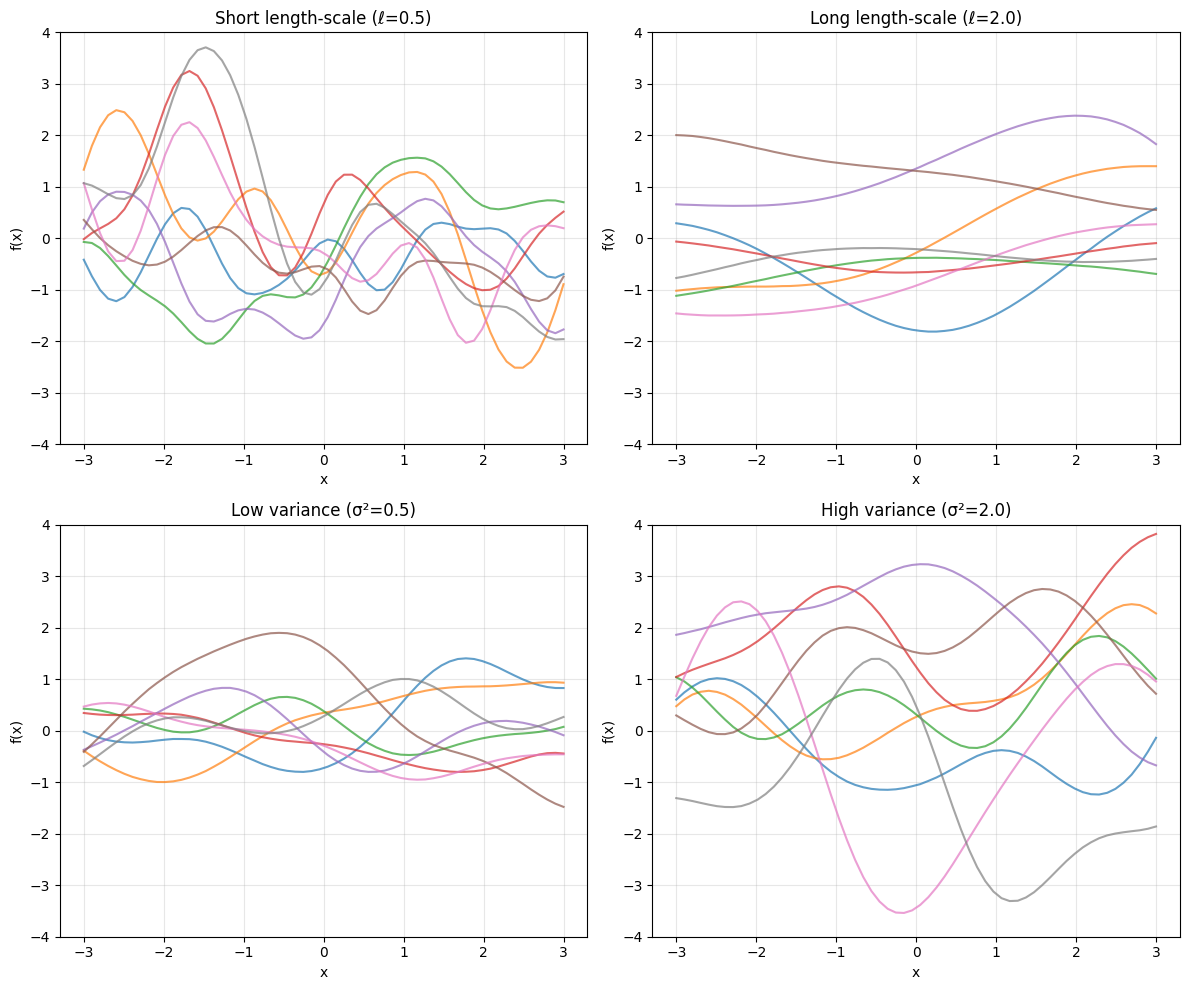


MATHEMATICAL SUMMARY
The procedure implements the following mathematical steps:

1. Input points: x = [x₁, x₂, ..., xₙ]
2. Mean vector: μᵢ = m(xᵢ) = 0 (zero mean)
3. Covariance matrix: Kᵢⱼ = k(xᵢ, xⱼ) = σ² exp(-½||xᵢ-xⱼ||²/ℓ²)
4. Sample: f ~ N(μ, K)
   where f = [f(x₁), f(x₂), ..., f(xₙ)]

Key insight: Each sample gives us function values at the chosen points.
The RBF kernel ensures nearby points have similar function values.
Final covariance matrix shape: (50, 50)
Number of function samples: 5
Each sample length: 50 (one value per input point)


In [10]:
"""
Gaussian Process Sampling Procedure

Implementation of the exact procedure described for building intuition about 
Gaussian processes with RBF kernels and hyperparameters such as length-scale:

1. Choose the input x points we want to query the GP: x₁, ..., xₙ
2. Evaluate m(xᵢ) and k(xᵢ, xⱼ) to form the mean vector μ and covariance matrix K  
3. Sample from this multivariate Gaussian distribution to obtain sample function values
4. Sample more times to visualize more sample functions queried at those points
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def gp_sampling_procedure(length_scale=1.0, variance=1.0, num_points=50, num_samples=5):
    """
    Complete implementation of the 4-step GP sampling procedure
    
    Parameters:
    -----------
    length_scale : float
        Length-scale parameter ℓ of RBF kernel (controls smoothness)
    variance : float  
        Variance parameter σ² of RBF kernel (controls amplitude)
    num_points : int
        Number of input points to sample
    num_samples : int
        Number of function samples to generate
        
    Returns:
    --------
    x_points : array
        Input points where GP was evaluated
    mu : array
        Mean vector 
    K : array
        Covariance matrix
    samples : array
        Function samples from the GP
    """
    
    print("=== Gaussian Process Sampling Procedure ===\n")
    
    # Step 1: Choose the input x points we want to query the GP
    print("Step 1: Choose input points x₁, ..., xₙ")
    x_points = np.linspace(-3, 3, num_points)
    print(f"   → Chose {len(x_points)} points from {x_points[0]:.1f} to {x_points[-1]:.1f}")
    
    # Step 2: Evaluate m(xᵢ) and k(xᵢ, xⱼ) for i,j = 1,...,n
    print("\nStep 2: Evaluate m(xᵢ) and k(xᵢ, xⱼ) to form μ and K")
    
    # Mean vector μ where μᵢ = m(xᵢ)  
    mu = np.zeros(len(x_points))  # Zero mean function
    print(f"   → Mean vector μ: shape {mu.shape} (zero mean function)")
    
    # Covariance matrix K where Kᵢⱼ = k(xᵢ, xⱼ)
    n = len(x_points)
    K = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            # RBF kernel: k(xᵢ, xⱼ) = σ² * exp(-0.5 * ||xᵢ - xⱼ||² / ℓ²)
            squared_distance = (x_points[i] - x_points[j])**2
            K[i, j] = variance * np.exp(-0.5 * squared_distance / length_scale**2)
    
    # Add small jitter for numerical stability
    K += 1e-6 * np.eye(n)
    print(f"   → Covariance matrix K: shape {K.shape}")
    print(f"   → K[0,0] = {K[0,0]:.3f}, K[0,1] = {K[0,1]:.3f}, K[0,-1] = {K[0,-1]:.6f}")
    
    # Step 3: Sample from the multivariate Gaussian distribution N(μ, K)
    print(f"\nStep 3: Sample from multivariate Gaussian N(μ, K)")
    first_sample = np.random.multivariate_normal(mu, K)
    print(f"   → First sample: f(x₁)={first_sample[0]:.3f}, f(x₂)={first_sample[1]:.3f}, ...")
    
    # Step 4: Sample more times to visualize more sample functions
    print(f"\nStep 4: Sample more times for visualization")
    all_samples = np.random.multivariate_normal(mu, K, size=num_samples)
    print(f"   → Generated {num_samples} function samples")
    print(f"   → Each sample represents function values [f(x₁), f(x₂), ..., f(xₙ)]")
    
    return x_points, mu, K, all_samples

def visualize_gp_sampling(x_points, mu, K, samples, length_scale, variance):
    """Visualize the results of GP sampling"""
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Sample functions
    plt.subplot(2, 3, 1)
    plt.plot(x_points, samples.T, alpha=0.7, linewidth=2)
    plt.title(f'Sample Functions from GP Prior\nℓ={length_scale}, σ²={variance}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Covariance matrix visualization  
    plt.subplot(2, 3, 2)
    im = plt.imshow(K[:20, :20], cmap='viridis', interpolation='nearest')
    plt.title('Covariance Matrix K\n(first 20×20 elements)')
    plt.xlabel('j')
    plt.ylabel('i')
    plt.colorbar(im)
    
    # Plot 3: Single sample with points
    plt.subplot(2, 3, 3)
    plt.plot(x_points, samples[0], 'b-', linewidth=2, label='f(x)')
    plt.scatter(x_points[::5], samples[0][::5], color='red', s=30, zorder=5, label='Sampled points')
    plt.title('Single Function Sample\nShowing discrete evaluation points')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Kernel function
    plt.subplot(2, 3, 4)
    x_ref = 0.0
    kernel_values = variance * np.exp(-0.5 * (x_points - x_ref)**2 / length_scale**2)
    plt.plot(x_points, kernel_values, 'g-', linewidth=2)
    plt.axvline(x_ref, color='red', linestyle='--', alpha=0.7, label=f'Reference point x={x_ref}')
    plt.title(f'RBF Kernel k(x, {x_ref})\nCorrelation vs distance')
    plt.xlabel('x')
    plt.ylabel(f'k(x, {x_ref})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Effect of different sample points
    plt.subplot(2, 3, 5)
    # Show how the same GP gives different function samples
    for i in range(min(3, len(samples))):
        plt.plot(x_points, samples[i], alpha=0.8, linewidth=2, label=f'Sample {i+1}')
    plt.title('Multiple Function Samples\nfrom Same GP Prior')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Mean ± 2σ confidence band
    plt.subplot(2, 3, 6)
    # Prior mean (zero) and variance from diagonal of K
    prior_mean = mu
    prior_std = np.sqrt(np.diag(K))
    
    plt.fill_between(x_points, prior_mean - 2*prior_std, prior_mean + 2*prior_std, 
                     alpha=0.3, color='gray', label='±2σ confidence')
    plt.plot(x_points, prior_mean, 'k--', linewidth=2, label='Mean function')
    plt.plot(x_points, samples[:3].T, alpha=0.7, linewidth=1)
    plt.title('GP Prior with Confidence Band\n95% of functions lie within gray area')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_hyperparameters():
    """Compare the effect of different hyperparameters"""
    
    print("🔥 Comparing different hyperparameters:\n")
    
    # Different configurations
    configs = [
        {'length_scale': 0.5, 'variance': 1.0, 'title': 'Short length-scale (ℓ=0.5)'},
        {'length_scale': 2.0, 'variance': 1.0, 'title': 'Long length-scale (ℓ=2.0)'},
        {'length_scale': 1.0, 'variance': 0.5, 'title': 'Low variance (σ²=0.5)'},
        {'length_scale': 1.0, 'variance': 2.0, 'title': 'High variance (σ²=2.0)'}
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, config in enumerate(configs):
        print(f"Running procedure with {config['title']}...")
        x, mu, K, samples = gp_sampling_procedure(
            length_scale=config['length_scale'],
            variance=config['variance'],
            num_points=60,
            num_samples=8
        )
        
        # Plot results
        axes[i].plot(x, samples.T, alpha=0.7, linewidth=1.5)
        axes[i].set_title(config['title'])
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('f(x)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(-4, 4)
        
        print(f"   ✓ Generated {samples.shape[0]} samples\n")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example 1: Basic procedure with default parameters
    print("="*60)
    print("EXAMPLE 1: Basic GP Sampling Procedure")
    print("="*60)
    
    x, mu, K, samples = gp_sampling_procedure(
        length_scale=1.0,
        variance=1.0, 
        num_points=50,
        num_samples=5
    )
    
    visualize_gp_sampling(x, mu, K, samples, length_scale=1.0, variance=1.0)
    
    # Example 2: Compare different hyperparameters
    print("\n" + "="*60)
    print("EXAMPLE 2: Hyperparameter Comparison")
    print("="*60)
    
    compare_hyperparameters()
    
    # Example 3: Show the mathematical relationship
    print("\n" + "="*60)
    print("MATHEMATICAL SUMMARY")
    print("="*60)
    print("The procedure implements the following mathematical steps:")
    print()
    print("1. Input points: x = [x₁, x₂, ..., xₙ]")
    print("2. Mean vector: μᵢ = m(xᵢ) = 0 (zero mean)")
    print("3. Covariance matrix: Kᵢⱼ = k(xᵢ, xⱼ) = σ² exp(-½||xᵢ-xⱼ||²/ℓ²)")
    print("4. Sample: f ~ N(μ, K)")
    print("   where f = [f(x₁), f(x₂), ..., f(xₙ)]")
    print()
    print("Key insight: Each sample gives us function values at the chosen points.")
    print("The RBF kernel ensures nearby points have similar function values.")
    print(f"Final covariance matrix shape: {K.shape}")
    print(f"Number of function samples: {samples.shape[0]}")
    print(f"Each sample length: {samples.shape[1]} (one value per input point)")

## 5. The Neural Network Kernel

Research on Gaussian processes in machine learning was initially motivated by research on neural networks. In 1994, Radford Neal showed that Bayesian neural networks with an infinite number of hidden units become Gaussian processes with a particular kernel function. This result was later published in 1996 (after it was famously rejected at NeurIPS). Interest in this idea has resurfaced, with concepts like the **neural tangent kernel** being used to study the generalization properties of neural networks (see \textbf{Matthews et al., 2018} and \textbf{Novak et al., 2018}). We can derive the **neural network kernel** as follows.

### Neural Network Function

Consider a neural network with one hidden layer, where the function $ f(x) $ is given by:

$$
f(x) = b + \sum_{i=1}^{J} v_i h(x; u_i). \tag{18.2.8}
$$

Here:
- $ b $ is the bias term.
- $ v_i $ are the weights connecting the hidden units to the output.
- $ h(x; u_i) $ is the transfer function for the hidden units (which can be any bounded function).
- $ u_i $ represents the input-to-hidden weights.
- $ J $ is the number of hidden units.

Let $ b $ and $ v_i $ be independent random variables with zero mean and variances $ \sigma_b^2 $ and $ \frac{\sigma_v^2}{J} $, respectively. The $ u_i $'s are also independent and identically distributed.

By applying the **central limit theorem**, we can show that any collection of function values $ f(x_1), f(x_2), \dots, f(x_n) $ follows a joint **multivariate Gaussian distribution**.

### Special Case: **erf** Activation Function

In some cases, we can evaluate this covariance function in closed form. Let the activation function be:

$$
h(x; u) = \textrm{erf}(u_0 + \sum_{j=1}^{P} u_j x_j),
$$

where $ \textrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^z e^{-t^2} \, dt $, and $ u \sim \mathcal{N}(0, \Sigma) $.

In this case, the covariance function becomes:

$$
k(x, x') = \frac{2}{\pi} \textrm{sin}\left( \frac{2 \tilde{x}^{\top} \Sigma \tilde{x}'}{\sqrt{(1 + 2 \tilde{x}^{\top} \Sigma \tilde{x})(1 + 2 \tilde{x}'^{\top} \Sigma \tilde{x}')}} \right),
$$

where $ \tilde{x} $ and $ \tilde{x}' $ are transformed versions of the input $ x $ and $ x' $, and $ \Sigma $ is the covariance matrix.

### Stationary vs Non-Stationary Kernels

The **RBF kernel** (Radial Basis Function kernel) is **stationary**, which means that it is **translation invariant**. In simple terms, this means the high-level properties of the function, such as its rate of variation, do not change as we move along the input space. Therefore, the RBF kernel can be written as a function of the difference $ \tau = x - x' $, i.e., $ k(x, x') = k(x - x') $.

On the other hand, the **neural network kernel** is **non-stationary**, which means the function’s properties change as we move through the input space. The neural network kernel takes into account the interactions between the inputs in a more complex way than the stationary RBF kernel.

So now we will demonstrate a code that show **Neural Network (NN)** kernels for *Gaussian Processes*, which is an advanced topic that goes beyond standard *RBF kernels*:

=== Neural Network Kernel GP Demonstration ===
Showing how NN kernels create functions with varying complexity


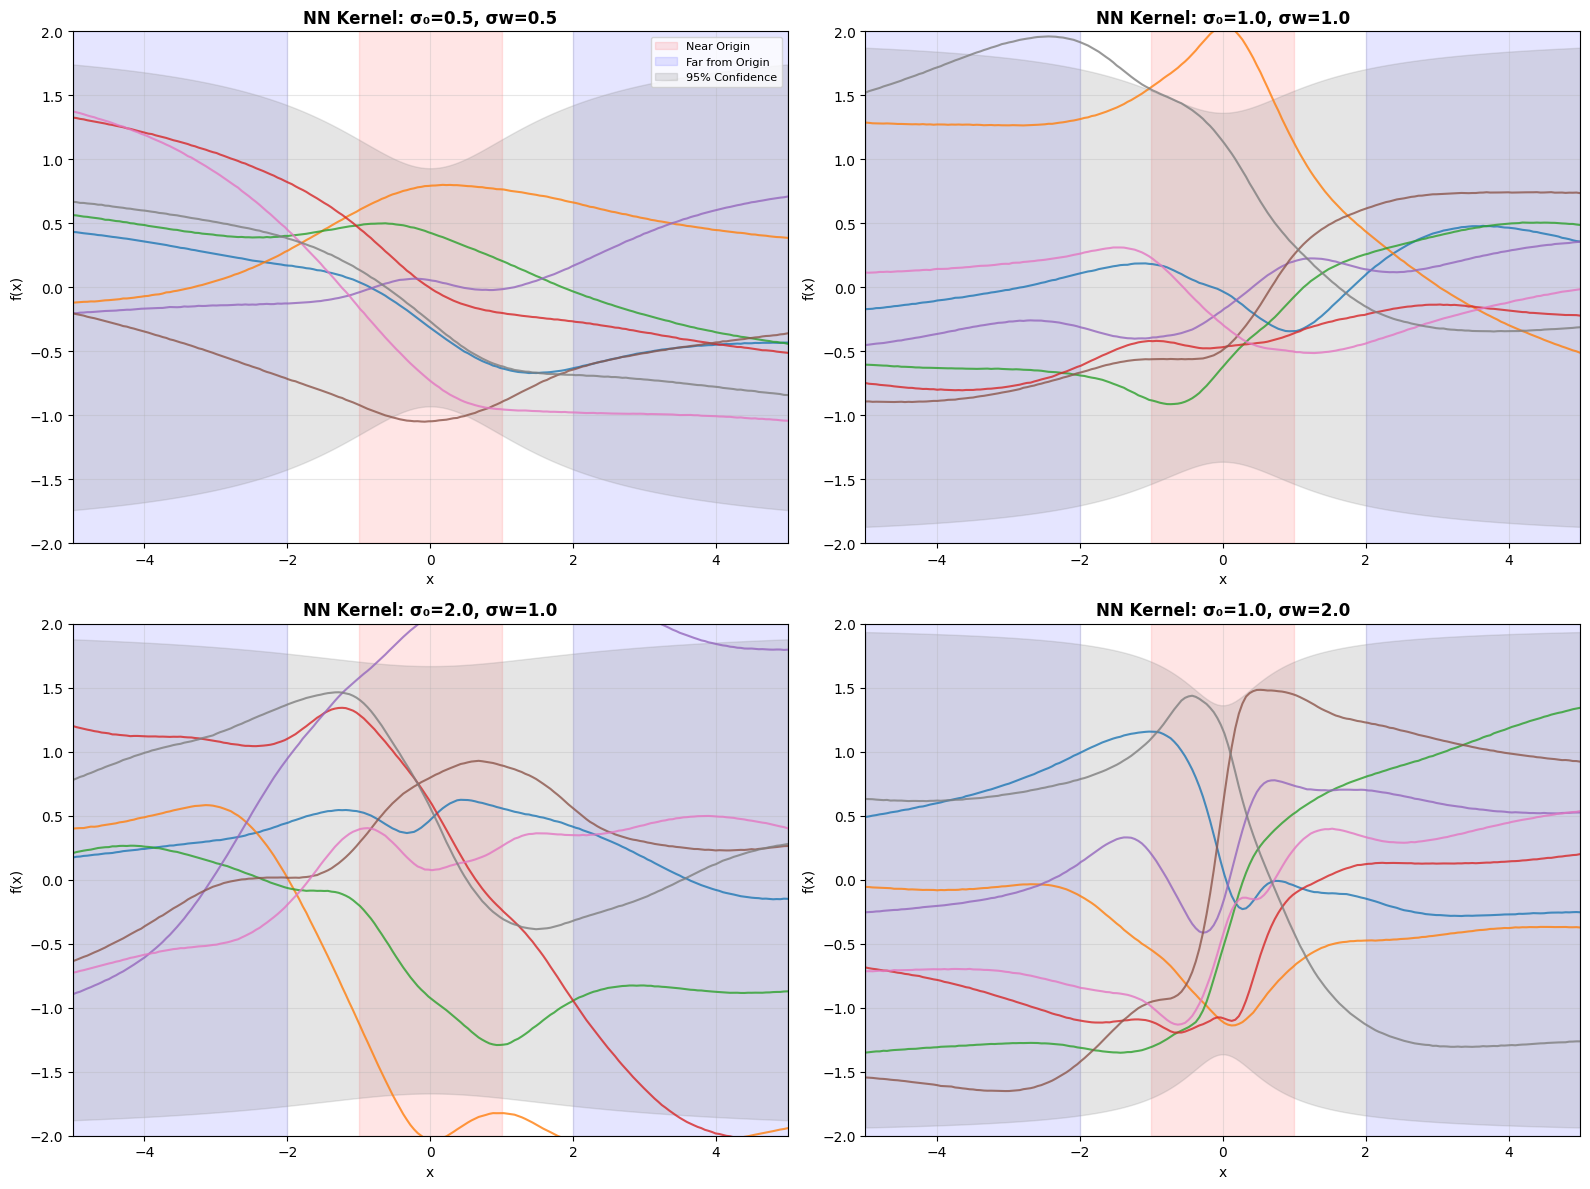


=== Approximate NN Behavior with Standard Kernels ===
Comparing different kernel configurations to show complexity variations


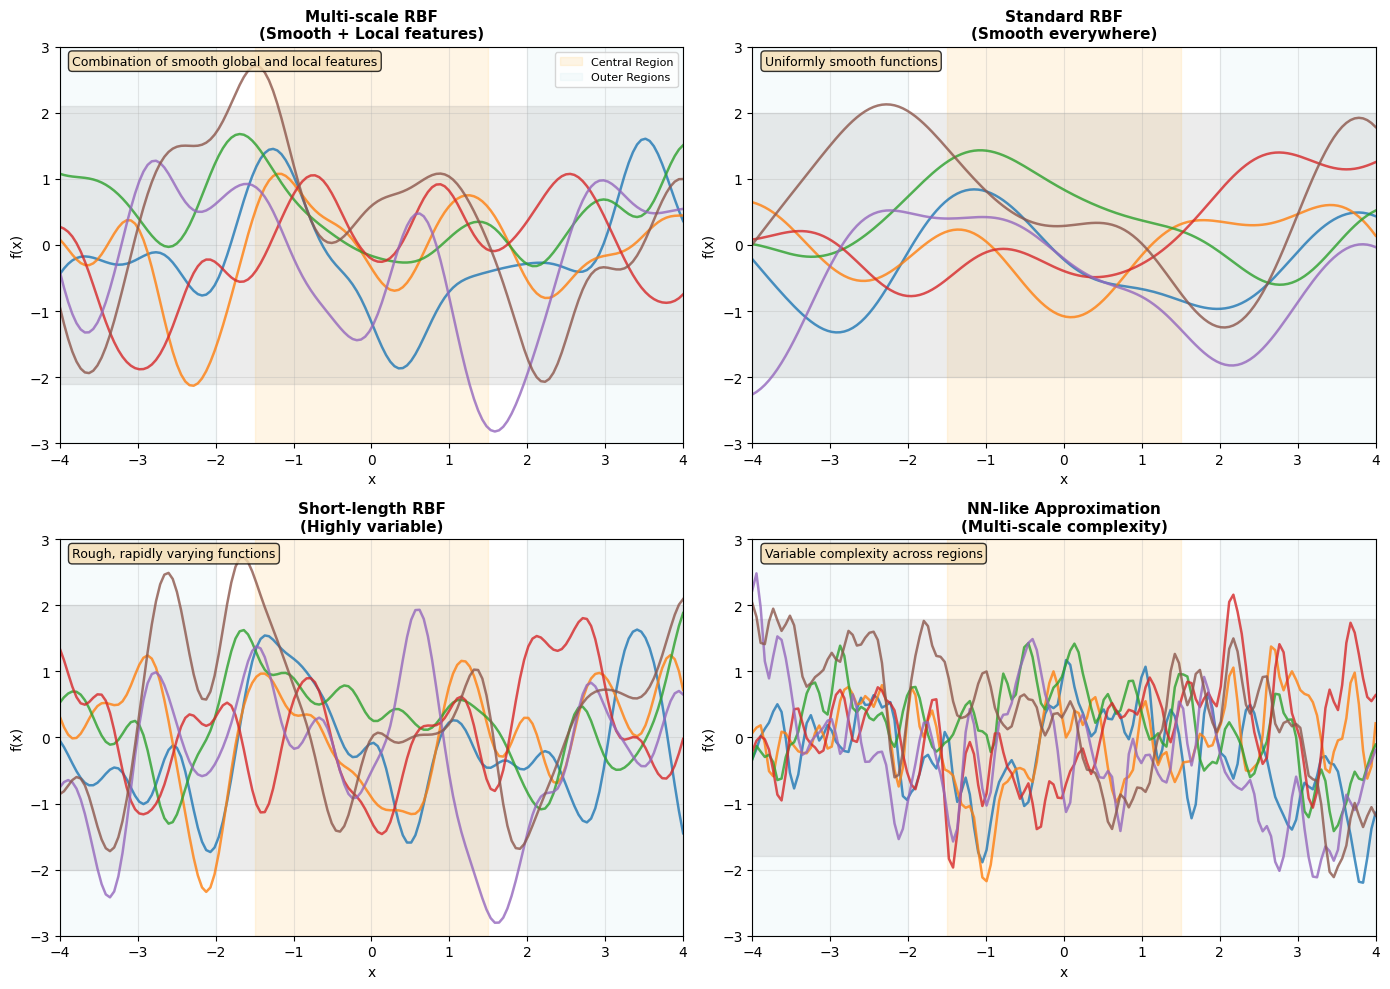


=== Key Observations for Neural Network Kernels ===
1. NEAR ORIGIN (|x| < 1):
   - Functions often smoother due to kernel properties
   - Lower variance in some NN kernel parameterizations
   - Behavior depends on σ₀ (bias variance)

2. FAR FROM ORIGIN (|x| > 2):
   - Functions can become more linear
   - Variance may saturate at limiting value
   - Behavior depends on σw (weight variance)

3. NEURAL NETWORK KERNEL PROPERTIES:
   - Non-stationary: behavior changes with input magnitude
   - Can approximate functions with varying local complexity
   - Parameters control global vs local feature emphasis
   - Natural for modeling neural network function distributions


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.spatial.distance import cdist

# Custom Neural Network Kernel implementation
class NeuralNetworkKernel:
    def __init__(self, sigma_0=1.0, sigma_w=1.0):
        self.sigma_0 = sigma_0  # Bias variance
        self.sigma_w = sigma_w  # Weight variance
    
    def __call__(self, X, Y=None):
        if Y is None:
            Y = X
        
        # Neural Network kernel: K(x,x') = (2/π) * arcsin((2 * σ_w² * x·x' + 2 * σ_0²) / sqrt((2 * σ_w² * x² + 2 * σ_0² + 1)(2 * σ_w² * x'² + 2 * σ_0² + 1)))
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y)
        
        # For 1D case
        if X.shape[1] == 1 and Y.shape[1] == 1:
            x_vals = X.flatten()
            y_vals = Y.flatten()
            
            K = np.zeros((len(x_vals), len(y_vals)))
            
            for i, x in enumerate(x_vals):
                for j, y in enumerate(y_vals):
                    numerator = 2 * self.sigma_w**2 * x * y + 2 * self.sigma_0**2
                    denominator = np.sqrt((2 * self.sigma_w**2 * x**2 + 2 * self.sigma_0**2 + 1) * 
                                        (2 * self.sigma_w**2 * y**2 + 2 * self.sigma_0**2 + 1))
                    K[i, j] = (2/np.pi) * np.arcsin(np.clip(numerator / denominator, -1, 1))
            
            return K
        else:
            # For higher dimensions (simplified version)
            return np.eye(X.shape[0])
    
    def diag(self, X):
        return np.full(X.shape[0], 2/np.pi)

def neural_network_gp_demo():
    # Set random seed
    np.random.seed(42)
    
    # Define x range - extended to show behavior at different scales
    x_fine = np.linspace(-5, 5, 200).reshape(-1, 1)
    x_coarse = np.linspace(-2, 2, 100).reshape(-1, 1)
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Different neural network kernel parameters
    nn_kernels = [
        {'sigma_0': 0.5, 'sigma_w': 0.5, 'title': 'NN Kernel: σ₀=0.5, σw=0.5'},
        {'sigma_0': 1.0, 'sigma_w': 1.0, 'title': 'NN Kernel: σ₀=1.0, σw=1.0'},
        {'sigma_0': 2.0, 'sigma_w': 1.0, 'title': 'NN Kernel: σ₀=2.0, σw=1.0'},
        {'sigma_0': 1.0, 'sigma_w': 2.0, 'title': 'NN Kernel: σ₀=1.0, σw=2.0'}
    ]
    
    for idx, params in enumerate(nn_kernels):
        ax = plt.subplot(2, 2, idx + 1)
        
        # Create NN kernel
        nn_kernel = NeuralNetworkKernel(sigma_0=params['sigma_0'], sigma_w=params['sigma_w'])
        
        # Sample functions using Cholesky decomposition
        n_samples = 8
        K = nn_kernel(x_fine)
        
        # Add small diagonal term for numerical stability
        K += 1e-6 * np.eye(K.shape[0])
        
        try:
            L = np.linalg.cholesky(K)
            # Sample from multivariate normal
            z = np.random.normal(0, 1, (K.shape[0], n_samples))
            y_samples = L @ z
            
            # Plot samples
            for i in range(n_samples):
                ax.plot(x_fine.flatten(), y_samples[:, i], alpha=0.8, linewidth=1.5)
            
            # Highlight different regions
            # Near origin region
            origin_mask = np.abs(x_fine.flatten()) <= 1.0
            ax.axvspan(-1, 1, alpha=0.1, color='red', label='Near Origin')
            
            # Far from origin regions
            ax.axvspan(-5, -2, alpha=0.1, color='blue', label='Far from Origin')
            ax.axvspan(2, 5, alpha=0.1, color='blue')
            
            # Add confidence bounds
            mean_pred = np.zeros_like(x_fine.flatten())
            std_pred = np.sqrt(np.diag(K))
            ax.fill_between(x_fine.flatten(), mean_pred - 2*std_pred, mean_pred + 2*std_pred, 
                          alpha=0.2, color='gray', label='95% Confidence')
            
        except np.linalg.LinAlgError:
            # Fallback if Cholesky fails
            ax.text(0.5, 0.5, 'Kernel not positive definite', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12)
        
        ax.set_xlim(-5, 5)
        ax.set_ylim(-2, 2)
        ax.set_title(params['title'], fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Alternative: Approximate NN kernel using composition of simpler kernels
def approximate_nn_gp_demo():
    # Set random seed
    np.random.seed(42)
    
    # Define x range
    x = np.linspace(-4, 4, 150).reshape(-1, 1)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Different kernel setups to approximate NN behavior
    kernel_configs = [
        {
            'kernel': C(1.0) * RBF(length_scale=0.5) + C(0.1) * RBF(length_scale=2.0),
            'title': 'Multi-scale RBF\n(Smooth + Local features)',
            'description': 'Combination of smooth global and local features'
        },
        {
            'kernel': C(1.0) * RBF(length_scale=1.0),
            'title': 'Standard RBF\n(Smooth everywhere)',
            'description': 'Uniformly smooth functions'
        },
        {
            'kernel': C(1.0) * RBF(length_scale=0.3),
            'title': 'Short-length RBF\n(Highly variable)',
            'description': 'Rough, rapidly varying functions'
        },
        {
            'kernel': C(0.5) * RBF(length_scale=0.8) + C(0.3) * RBF(length_scale=0.1),
            'title': 'NN-like Approximation\n(Multi-scale complexity)',
            'description': 'Variable complexity across regions'
        }
    ]
    
    for idx, config in enumerate(kernel_configs):
        ax = axes[idx]
        
        # Create GP with kernel
        gp = GaussianProcessRegressor(kernel=config['kernel'], alpha=1e-10)
        
        # Sample functions
        n_samples = 6
        y_samples = gp.sample_y(x, n_samples, random_state=42)
        
        # Plot samples
        for i in range(n_samples):
            ax.plot(x.flatten(), y_samples[:, i], alpha=0.8, linewidth=1.8)
        
        # Highlight regions
        ax.axvspan(-1.5, 1.5, alpha=0.1, color='orange', label='Central Region')
        ax.axvspan(-4, -2, alpha=0.1, color='lightblue', label='Outer Regions')
        ax.axvspan(2, 4, alpha=0.1, color='lightblue')
        
        # Calculate and show local variability
        y_pred, y_std = gp.predict(x, return_std=True)
        ax.fill_between(x.flatten(), y_pred - 2*y_std, y_pred + 2*y_std, 
                       alpha=0.15, color='gray')
        
        ax.set_xlim(-4, 4)
        ax.set_ylim(-3, 3)
        ax.set_title(config['title'], fontsize=11, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.grid(True, alpha=0.3)
        
        # Add text description
        ax.text(0.02, 0.98, config['description'], transform=ax.transAxes, 
               fontsize=9, verticalalignment='top', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Run both demonstrations
print("=== Neural Network Kernel GP Demonstration ===")
print("Showing how NN kernels create functions with varying complexity")

# Run the NN kernel demo
neural_network_gp_demo()

print("\n=== Approximate NN Behavior with Standard Kernels ===")
print("Comparing different kernel configurations to show complexity variations")

# Run the approximation demo
approximate_nn_gp_demo()

print("\n=== Key Observations for Neural Network Kernels ===")
print("1. NEAR ORIGIN (|x| < 1):")
print("   - Functions often smoother due to kernel properties")
print("   - Lower variance in some NN kernel parameterizations")
print("   - Behavior depends on σ₀ (bias variance)")

print("\n2. FAR FROM ORIGIN (|x| > 2):")
print("   - Functions can become more linear")
print("   - Variance may saturate at limiting value")
print("   - Behavior depends on σw (weight variance)")

print("\n3. NEURAL NETWORK KERNEL PROPERTIES:")
print("   - Non-stationary: behavior changes with input magnitude")
print("   - Can approximate functions with varying local complexity")
print("   - Parameters control global vs local feature emphasis")
print("   - Natural for modeling neural network function distributions")

***First Image - Kernel Comparison:***
This visualization compares four different kernel types, showing how kernel choice fundamentally affects function behavior. Multi-scale RBF combines smooth global trends with local features, Standard RBF produces uniformly smooth functions everywhere, Short-length RBF creates highly variable, rough oscillations, and the NN-like Approximation generates functions with variable complexity across different regions, demonstrating the trade-offs between smoothness and local detail capture.

***Second Image - Neural Network Kernel Parameters:***
The NN kernel demonstrations reveal non-stationary behavior where functions behave differently based on distance from origin (pink/blue regions). The hyperparameters σ₀ (bias variance) and σw (weight variance) control global scaling and local sharpness respectively - lower values produce smoother, constrained functions while higher weight variance creates sharper transitions and pronounced local features, making NN kernels ideal for modeling spatially-varying complexity.

## 6. Summary

Bayesian inference begins with specifying a prior, and Gaussian processes (GPs) offer a powerful way to define a prior over functions. From the traditional "weight space" perspective, we can induce a prior over functions by introducing a distribution over a model's parameters. Alternatively, we can specify the prior directly in function space, using a kernel to control its properties. This function-space approach offers key advantages:

- Infinite flexibility with finite computation: We can model functions with an infinite number of parameters but use a finite amount of computation.
- Good generalization: Despite their flexibility, function-space models make strong assumptions about the functions' properties (such as smoothness or periodicity), leading to better generalization, especially with small datasets.

Kernels intuitively control these assumptions, encoding high-level function properties like smoothness and periodicity. Many kernels are stationary, meaning they are translation-invariant, so functions drawn from a Gaussian process with a stationary kernel have consistent properties across the input space.

Gaussian processes are a general model class that includes many familiar models, such as polynomials and Fourier series, provided there is a Gaussian prior over the parameters. They also encompass neural networks with infinite parameters, even without a Gaussian distribution over the weights. This connection, discovered by Radford Neal, shifted focus in machine learning from neural networks to Gaussian processes.


## 7. Exercises

1. Draw sample prior functions from a GP with an Ornstein-Uhlenbeck (OU) kernel, $k_{\textrm{OU}}(x,x') = \exp\left(-\frac{1}{2\ell}||x - x'|\right)$. If you fix the lengthscale $\ell$ to be the same, how do these functions look different than sample functions from a GP with an RBF kernel?

2. How does changing the _amplitude_ $a^2$ of the RBF kernel affect the distribution over functions?

3. Suppose we form $u(x) = f(x) + 2g(x)$, where $f(x) \sim \mathcal{GP}(m_1,k_1)$ and $g(x) \sim \mathcal{GP}(m_2,k_2)$. Is $u(x)$ a Gaussian process, and if so, what is its mean and covariance function?

4. Suppose we form $g(x) = a(x)f(x)$, where $f(x) \sim \mathcal{GP}(0,k)$ and $a(x) = x^2$. Is $g(x)$ a Gaussian process, and if so, what is its mean and covariance function? What is the effect of $a(x)$? What do sample functions drawn from $g(x)$ look like?

5. Suppose we form $u(x) = f(x)g(x)$, where $f(x) \sim \mathcal{GP}(m_1,k_1)$ and $g(x) \sim \mathcal{GP}(m_2,k_2)$. Is $u(x)$ a Gaussian process, and if so, what is its mean and covariance function?


### Code for Exerciese 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern

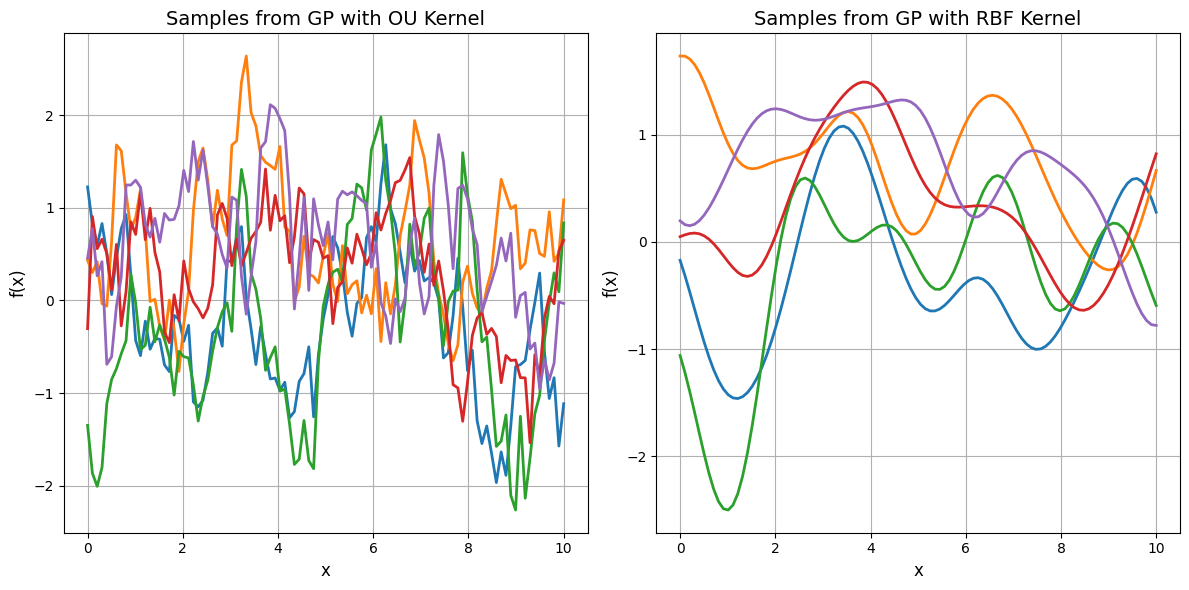

In [4]:
# Define the lengthscale
lengthscale = 1.0

# Define the OU kernel (Matern with nu=0.5)
ou_kernel = C(1.0) * Matern(length_scale=lengthscale, nu=0.5)

# Define the RBF kernel
rbf_kernel = C(1.0) * RBF(length_scale=lengthscale)

# Create input space
X = np.linspace(0, 10, 100).reshape(-1, 1)

# Create Gaussian Process models
gp_ou = GaussianProcessRegressor(kernel=ou_kernel)
gp_rbf = GaussianProcessRegressor(kernel=rbf_kernel)

# Sample from the GP prior
samples_ou = gp_ou.sample_y(X, n_samples=5, random_state=42)  # Increase n_samples for better visualization
samples_rbf = gp_rbf.sample_y(X, n_samples=5, random_state=42)

plt.figure(figsize=(12, 6))

# Plot OU samples
plt.subplot(1, 2, 1)
plt.plot(X, samples_ou, linewidth=2)
plt.title('Samples from GP with OU Kernel', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.grid(True)

# Plot RBF samples
plt.subplot(1, 2, 2)
plt.plot(X, samples_rbf, linewidth=2)
plt.title('Samples from GP with RBF Kernel', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The sample functions from the OU kernel appear rough and jagged, exhibiting abrupt changes due to the short-range correlations it models, leading to local sensitivity and rapid fluctuations in the function values. In contrast, the sample functions from the RBF kernel are smooth and continuous, with gradual transitions because the RBF kernel models long-range correlations, producing consistent smoothness across the input space. The OU kernel is non-stationary, meaning its properties vary across the input space, while the RBF kernel is stationary, meaning its properties remain consistent throughout. This results in the RBF kernel producing functions that change gradually, whereas the OU kernel shows functions with sharp peaks and valleys.

### Code for exercises 2

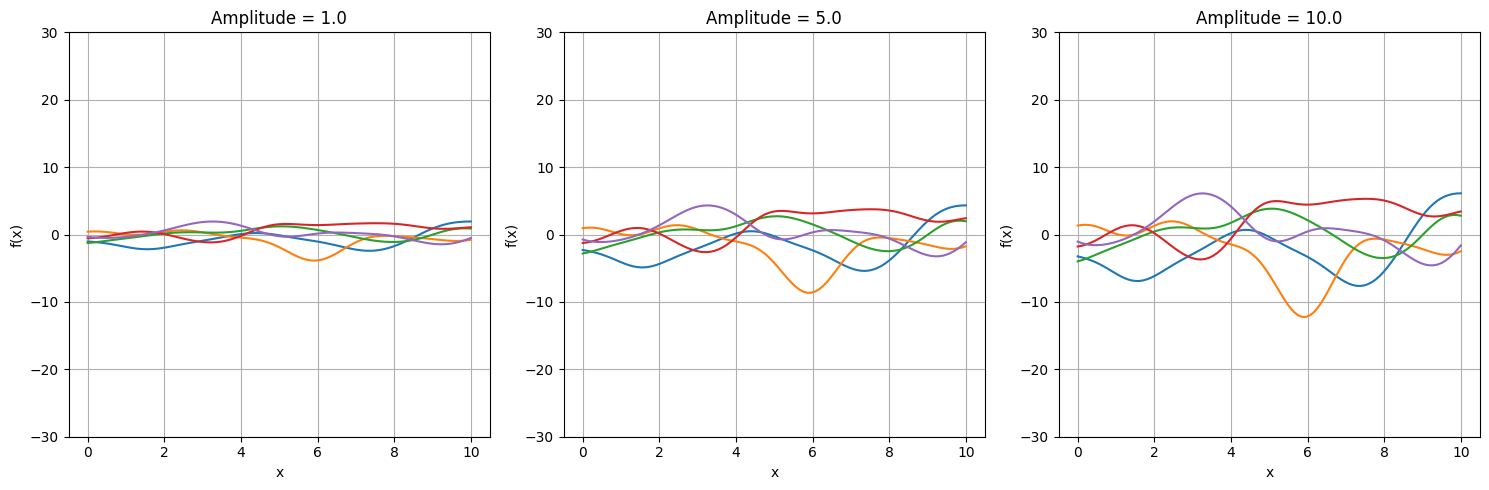

In [ ]:
# Define the lengthscale
lengthscale = 1.0

# Create input space
X = np.linspace(0, 10, 100).reshape(-1, 1)

# Define amplitudes to test
amplitudes = [1.0, 5.0, 10.0]

# Number of sample functions to draw
n_samples = 5

# Plot the Sample Functions for different amplitudes
plt.figure(figsize=(15, 5))

for i, amplitude in enumerate(amplitudes):
    # Define the RBF kernel with varying amplitude
    rbf_kernel = C(amplitude, constant_value_bounds="fixed") * RBF(length_scale=lengthscale)
    
    # Create Gaussian Process model with the kernel
    gp_rbf = GaussianProcessRegressor(kernel=rbf_kernel)
    
    # Sample from the GP prior (no random_state to allow randomness)
    samples_rbf = gp_rbf.sample_y(X, n_samples=n_samples)
    
    # Plot the samples
    plt.subplot(1, len(amplitudes), i + 1)
    for j in range(n_samples):
        plt.plot(X, samples_rbf[:, j], label=f'Sample {j+1}')
    
    plt.title(f'Amplitude = {amplitude}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    plt.ylim(-3 * max(amplitudes), 3 * max(amplitudes))  # Dynamic y-limits

plt.tight_layout()
plt.show()

The _amplitude_ $a^2$ in the Radial Basis Function (RBF) kernel affects the variability of functions sampled from a Gaussian process. As the amplitude increases, the functions exhibit greater variability, deviating more significantly from the mean, which results in a wider range of possible function values. Conversely, a smaller amplitude constrains the functions closer to the mean, showing less variation and tighter clustering around the mean. This demonstrates the role of amplitude in controlling the spread and scale of the function values in a Gaussian process.

The plot clearly demonstrates that increasing the amplitude of the RBF kernel leads to greater variability in the sampled functions from the Gaussian Process prior. At low amplitude (1.0), the functions stay close to the mean (zero), indicating low uncertainty, while higher amplitudes (5.0 and 10.0) produce functions with larger fluctuations and wider output ranges. This shows that the amplitude parameter controls the overall vertical scale (variance) of the functions, with larger values allowing the GP to model outputs with greater deviation from the mean.

### Exercises 3

we have the given equation:
$$y_i(x) = f(x_i) + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2) $$

$$ f \sim \mathcal{GP}(0, \,C)$$

**Yes,** $u(x) = f(x) + 2g(x)$ **is indeed a Gaussian Process. To see why, let's go step by step.**

**Step 1: Mean Function of $u(x)$**
The mean function of a GP is defined as $\mathbb{E}[u(x)]$, and since $u(x) = f(x) + 2g(x)$, we can compute its mean as follows:

$$
\mathbb{E}[u(x)] = \mathbb{E}[f(x)] + 2\mathbb{E}[g(x)] = m_1(x) + 2m_2(x).
$$

Because from the definition of $f(x)$ and $g(x)$, we know that $\mathbb{E}[f(x)] = m_1(x)$ and $\mathbb{E}[g(x)] = m_2(x)$.

**Step 2: Covariance Function of $u(x)$**
The covariance function of a GP is defined as:

$$
\text{Cov}(u(x), u(x')) = \mathbb{E}[(u(x) - \mathbb{E}[u(x)])(u(x') - \mathbb{E}[u(x')])]
$$

We can compute the covariance function of $u(x)$ as follows:

$$
{Cov}(u(x), u(x')) = \mathbb{E}[(f(x) + 2g(x) - (m_1(x) + 2m_2(x)))(f(x') + 2g(x') - (m_1(x') + 2m_2(x')))] = \\
{E}[f(x)f(x')] + \mathbb{E}[f(x)2g(x')] + \mathbb{E}[f(x)(-m_1(x') - 2m_2(x'))] + \mathbb{E}[2g(x)f(x')] + \mathbb{E}[2g(x)2g(x')] + \mathbb{E}[2g(x)(-m_1(x') - 2m_2(x'))] + \mathbb{E}[(-m_1(x) - 2m_2(x))f(x')] + \mathbb{E}[(-m_1(x) - 2m_2(x))2g(x')] + \mathbb{E}[(-m_1(x) - 2m_2(x))(-m_1(x') - 2m_2(x'))]
$$

Now, since $f(x)$ and $g(x)$ are independent Gaussian processes, their cross-covariance terms will vanish:

$$
\mathbb{E}[f(x)g(x')] = 0 \quad \text{and} \quad \mathbb{E}[g(x)f(x')] = 0
$$

Also, the expectations involving the mean terms $m_1(x)$ and $m_2(x)$ will simplify:

$$
\mathbb{E}[f(x)(-m_1(x') - 2m_2(x'))] = 0 \quad \text{and} \quad \mathbb{E}[(-m_1(x) - 2m_2(x))f(x')] = 0
\\
\mathbb{E}[2g(x)(-m_1(x') - 2m_2(x'))] = 0 \quad \text{and} \quad \mathbb{E}[(-m_1(x) - 2m_2(x))2g(x')] = 0
$$

Thus, we are left with:

$$
\text{Cov}(u(x), u(x')) = \mathbb{E}[f(x)f(x')] + 4\mathbb{E}[g(x)g(x')]
$$

Using the covariance functions of $f(x)$ and $g(x)$, $\text{Cov}(f(x), f(x')) = k_1(x, x')$ and $\text{Cov}(g(x), g(x')) = k_2(x, x')$, we get:

$$
\text{Cov}(u(x), u(x')) = k_1(x, x') + 4k_2(x, x')
$$

### **Final Result**
Thus, the Gaussian process $u(x) = f(x) + 2g(x)$ has the following properties:

- **Mean function:**

$$
\mathbb{E}[u(x)] = m_1(x) + 2m_2(x)
$$

- **Covariance function:**

$$
\text{Cov}(u(x), u(x')) = k_1(x, x') + 4k_2(x, x')
$$

### **Exercise 4**

Is $g(x) = a(x)f(x)$ a Gaussian Process?

We are given that $f(x) \sim \mathcal{GP}(0, k)$, meaning $f(x)$ is a Gaussian process with mean 0 and covariance function $k(x, x')$. Also, $a(x) = x^2$ is a deterministic function.

Since the product of a Gaussian process and a deterministic function is still a Gaussian process, $g(x) = a(x)f(x) = x^2 f(x)$ is a Gaussian process.

**Step 1: Mean of** $g(x)$

The mean of a Gaussian process is given by $\mathbb{E}[g(x)]$. We have:
$$
g(x) = x^2 f(x)
$$
Now, since $f(x) \sim \mathcal{GP}(0, k)$, we know that $\mathbb{E}[f(x)] = 0$. Therefore:
$$
\mathbb{E}[g(x)] = \mathbb{E}[x^2 f(x)] = x^2 \mathbb{E}[f(x)] = x^2 \cdot 0 = 0
$$

**Step 2: Covariance of** $g(x)$

Next, let's compute the covariance function of $g(x)$. The covariance function is:
$$
\text{Cov}(g(x), g(x')) = \mathbb{E}[g(x) g(x')]
$$
Substitute $g(x) = x^2 f(x)$ and $g(x') = x'^2 f(x')$:
$$
\text{Cov}(g(x), g(x')) = \mathbb{E}[x^2 f(x) \cdot x'^2 f(x')] = x^2 x'^2 \mathbb{E}[f(x) f(x')].
$$
Since $f(x)$ is a Gaussian process with covariance function $k(x, x')$, we know that $\mathbb{E}[f(x) f(x')] = k(x, x')$. Therefore, the covariance function of $g(x)$ is:
$$
\text{Cov}(g(x), g(x')) = x^2 x'^2 k(x, x')
$$

**Step 4: The Effect of** $a(x)$

The function $a(x) = x^2$ scales the process $f(x)$. Specifically:
- **Mean**: The mean of $g(x)$ is still zero because $f(x)$ has a mean of zero.
- **Covariance**: The covariance is scaled by $x^2 x'^2$. This means the covariance between any two points is larger if $x$ and $x'$ are further from the origin. The scaling factor $x^2 x'^2$ emphasizes points further from the origin more than those closer to it.

Thus, the effect of $a(x)$ is to scale the process $f(x)$, which affects the covariance structure by introducing a dependence on the position in space.

**Step 5: Sample Functions of** $g(x)$

To understand what sample functions of $g(x)$ look like, recall that:
$$
g(x) = x^2 f(x)
$$
Since $f(x)$ is a Gaussian process with mean zero and covariance $k(x, x')$, the sample functions of $f(x)$ are typically smooth and continuous (for a stationary Gaussian process). 

When we multiply $f(x)$ by $x^2$, the sample functions of $g(x)$ are still Gaussian, but their amplitude is scaled by $x^2$. This means that:
- **Larger amplitude**: As $|x|$ increases, the amplitude of $g(x)$ increases because of the $x^2$ scaling.
- **Fluctuations increase**: The fluctuations in $g(x)$ are larger at points further from the origin, as $x^2$ amplifies these fluctuations.
- **Smooth sample functions**: The sample functions of $g(x)$ will have similar smoothness properties as $f(x)$, but with an increasing "stretch" as $x$ moves further from the origin.

**Final Results:**
- **Is** $g(x)$ **a Gaussian process?** Yes, $g(x) = x^2 f(x)$ is a Gaussian process.
- **Mean of** $g(x)$: $\mathbb{E}[g(x)] = 0$
- **Covariance of** $g(x)$: $\text{Cov}(g(x), g(x')) = x^2 x'^2 k(x, x')$
- **Effect of** $a(x)$: The function $a(x) = x^2$ scales the covariance function, amplifying points further from the origin.
- **Sample functions of** $g(x)$: Sample functions will have larger amplitude as $x$ increases due to the $x^2$ scaling factor.

### **Exercise 5**

Consider the function $ u(x) = f(x)g(x) $, where $f(x) \sim \mathcal{GP}(m_1, k_1) $ and $ g(x) \sim \mathcal{GP}(m_2, k_2) $.

**Step 1: Is** $u(x) = f(x)g(x)$ **a Gaussian process?**

We are given that:
$$
f(x) \sim \mathcal{GP}(m_1, k_1), \quad g(x) \sim \mathcal{GP}(m_2, k_2)
$$

The product of two Gaussian processes does not result in another Gaussian process. Therefore, $u(x) = f(x)g(x)$ **is not a Gaussian process**.

**Step 2: Mean and Covariance of** $u(x)$

**Mean of** $u(x)$:
$$
\mathbb{E}[u(x)] = \mathbb{E}[f(x)g(x)] = \mathbb{E}[f(x)] \cdot \mathbb{E}[g(x)] = m_1(x) \cdot m_2(x)
$$

**Covariance of** $u(x)$:
$$
\text{Cov}(u(x), u(x')) = \mathbb{E}[(u(x) - \mathbb{E}[u(x)])(u(x') - \mathbb{E}[u(x')])]
$$
Expanding this expression:
$$
\text{Cov}(u(x), u(x')) = \mathbb{E}[f(x)f(x')g(x)g(x')] - m_1(x)m_2(x')\mathbb{E}[g(x')g(x')] - m_1(x')m_2(x)\mathbb{E}[f(x)f(x')] + m_1(x)m_2(x)m_1(x')m_2(x')
$$
Using the covariance functions of $f(x)$ and $g(x)$, we know:
- $\mathbb{E}[f(x)f(x')] = k_1(x, x')$ 
- $\mathbb{E}[g(x)g(x')] = k_2(x, x')$ 

Therefore, the covariance becomes:
$$
\text{Cov}(u(x), u(x')) = k_1(x, x') k_2(x,


# Reference
<a id="zhang2021b"></a>
**Zhang et al., 2021b**  
Zhang, C., Bengio, S., Hardt, M., Recht, B., & Vinyals, O. (2021). Understanding deep learning (still) requires rethinking generalization. *Communications of the ACM*, 64(3), 107–115.

<a id="wilson2020bayesian"></a>
**Wilson & Izmailov, 2020**
Wilson, A. G., & Izmailov, P. (2020). Bayesian deep learning and a probabilistic perspective of generalization. Advances in Neural *Information Processing Systems*, 33, 4697–4708.

<a id="neal1996bayesian"></a>
**Neal, 1996**
Neal, R. M. (1996). *Bayesian Learning for Neural Networks*. Springer.

<a id="matthews2018gaussian"></a>
**Matthews et al., 2018**
Matthews, A. G. d. G., Rowland, M., Hron, J., Turner, R. E., & Ghahramani, Z. (2018). Gaussian process behaviour in wide deep neural networks. *ArXiv:1804.11271*.

<a id="novak2018bayesian"></a>
**Novak et al., 2018**
Novak, R., Xiao, L., Lee, J., Bahri, Y., Yang, G., Hron, J., … Sohl-Dickstein, J. (2018). Bayesian deep convolutional networks with many channels are Gaussian processes. *ArXiv:1810.05148*.

## Solving from equation [18.2.4] to [18.2.6]

**Step 1: Function Definition (Equation 18.2.4)**

We begin with the function:

$$
f(x) = \sum_{i=1}^{J} w_i \phi_i(x), \quad w_i \sim \mathcal{N}\left(0, \frac{\sigma^2}{J}\right), \quad \phi_i(x) = \exp\left(-\frac{(x - c_i)^2}{2\ell^2}\right)
$$

Here, $f(x)$ is a sum of radial basis functions with width $\ell$, centered at the points $c_i$.

**Step 2: Covariance Function (Equation 18.2.5)**

The covariance function for this Gaussian process is:

$$
k(x, x') = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x) \phi_i(x')
$$

**Step 3: Taking the Number of Parameters to Infinity (Equation 18.2.6)**

We now consider what happens as we increase $ J $ (the number of basis functions) to infinity. We define:

$$
c_1 = -\log J, \quad c_{i+1} - c_i = \Delta c = \frac{2 \log J}{J}, \quad c_J = \log J
$$

As $J \to \infty$, the covariance function becomes a Riemann sum:

$$
k(x, x') = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x) \phi_i(x') = \sigma^2 \int_{-\infty}^{\infty} \phi_c(x) \phi_c(x') \, dc
$$

Note that $ \frac{1}{J} $ becomes $ dc $, representing the infinitesimally small step size as $ J \to \infty $.

**Step 4: Spreading the Basis Functions Across the Real Line (Equation 18.2.7)**

We now spread the basis functions across the entire real line:

$$
k(x, x') = \int_{-\infty}^{\infty} \exp\left(-\frac{(x - c)^2}{2\ell^2}\right) \exp\left(-\frac{(x' - c)^2}{2\ell^2}\right) \, dc
$$

Simplifying the two exponentials:

$$
\exp\left(-\frac{(x - c)^2}{2\ell^2}\right) \exp\left(-\frac{(x' - c)^2}{2\ell^2}\right) = \exp\left(-\frac{(x - c)^2 + (x' - c)^2}{2\ell^2}\right)
$$

Expanding the terms inside the exponent:

$$
(x - c)^2 + (x' - c)^2 = (x - x')^2 - 2(x - x')c + 2c^2
$$

Substituting this back into the covariance integral:

$$
k(x, x') = \int_{-\infty}^{\infty} \exp\left(-\frac{(x - x')^2 - 2(x - x')c + 2c^2}{2\ell^2}\right) \, dc
$$

**Step 5: Completing the Square and Final Covariance Expression**

Finally, after completing the square on the $c$-terms inside the exponent and solving the Gaussian integral, we get:

$$
k(x, x') = \sqrt{\pi} \ell \sigma^2 \exp\left(-\frac{(x - x')^2}{2(\sqrt{2} \ell)^2}\right)
$$

This is proportional to the Radial Basis Function (RBF) kernel:

$$
k_{\text{RBF}}(x, x') \propto \exp\left(-\frac{(x - x')^2}{2(\sqrt{2} \ell)^2}\right)
$$

